In this Build week project I predict the yield of corn in Illinois

---



Import packages 

In [31]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [32]:
import category_encoders as ce
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            plot_confusion_matrix, classification_report

In [33]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [34]:
pip install pybaseball

Import data set from https://purr.purdue.edu/publications/3046/about?v=2

In [6]:
from google.colab import files
uploaded = files.upload()

Saving yields_weather_1970_2015.csv to yields_weather_1970_2015 (1).csv


Read the Data

In [7]:
import pandas as pd
df = pd.read_csv('yields_weather_1970_2015.csv')

Explorotary Data Analysis

In [8]:
df.head()

,Unnamed: 0,County,Year,Month,Day,State,Precipitation (in),Average Temperature (F),Annual Corn Yield (BU/ACRE),Growing Degree Days (Base: 50F),Annual Acres Harvested - Corn,Annual.Wheat.Yield..BU.ACRE.,Annual.soybeans.Yield..BU.ACRE.
0,1,17001,1970,8,26,IL,0.000000,74.000000,79.0,24.000000,120200.0,34.0,32.5
1,2,17001,1970,4,20,IL,0.223333,48.333333,79.0,0.000000,120200.0,34.0,32.5
2,3,17001,1970,8,18,IL,0.526667,78.500000,79.0,28.500000,120200.0,34.0,32.5
3,4,17001,1970,7,16,IL,0.000000,71.833333,79.0,21.833333,120200.0,34.0,32.5
4,5,17001,1970,8,30,IL,0.000000,81.125000,79.0,31.125000,120200.0,34.0,32.5


In [9]:
##I'm dropping these values because it's not important to predict the corn of the yield 
df = df.drop(['Annual.Wheat.Yield..BU.ACRE.'], axis =1)
df = df.drop(['Annual.soybeans.Yield..BU.ACRE.'], axis =1)
df = df.drop(['County'], axis =1)

In [10]:
df.shape

(1048575, 10)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Unnamed: 0                       1048575 non-null  int64  
 1   Year                             1048575 non-null  int64  
 2   Month                            1048575 non-null  int64  
 3   Day                              1048575 non-null  int64  
 4   State                            1048575 non-null  object 
 5   Precipitation (in)               970900 non-null   float64
 6   Average Temperature (F)          816131 non-null   float64
 7   Annual Corn Yield (BU/ACRE)      1048575 non-null  float64
 8   Growing Degree Days (Base: 50F)  816131 non-null   float64
 9   Annual Acres Harvested - Corn    1048575 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 80.0+ MB


Drop Missing Values

In [13]:
df.isnull().sum()

Unnamed: 0                              0
Year                                    0
Month                                   0
Day                                     0
State                                   0
Precipitation (in)                  77675
Average Temperature (F)            232444
Annual Corn Yield (BU/ACRE)             0
Growing Degree Days (Base: 50F)    232444
Annual Acres Harvested - Corn           0
dtype: int64

In [14]:
##leaky Feature
df = df.drop(['Annual Acres Harvested - Corn'], axis =1)


In [15]:
df.dropna(inplace = True)

In [16]:
df.describe()

,Unnamed: 0,Year,Month,Day,Precipitation (in),Average Temperature (F),Annual Corn Yield (BU/ACRE),Growing Degree Days (Base: 50F)
count,7.972680e+05,797268.000000,797268.000000,797268.000000,797268.000000,797268.000000,797268.000000,797268.000000
mean,5.612582e+05,1992.362344,6.539709,15.729742,0.115129,52.530757,125.955084,9.827717
std,2.909999e+05,13.128579,3.427568,8.798923,0.299221,19.860268,36.089226,11.035859
min,1.000000e+00,1970.000000,1.000000,1.000000,0.000000,-22.500000,19.000000,0.000000
25%,3.168718e+05,1981.000000,4.000000,8.000000,0.000000,37.166667,101.000000,0.000000
50%,5.852055e+05,1993.000000,7.000000,16.000000,0.000000,54.750000,126.000000,4.750000
75%,8.172352e+05,2004.000000,10.000000,23.000000,0.070000,69.666667,150.500000,19.666667
max,1.042756e+06,2015.000000,12.000000,31.000000,9.240000,93.500000,236.000000,43.500000


Split Data 

In [17]:


train = df[df['Year'] <= 1970] 
val = df[df['Year'] == 1970]   
test = df[df['Year'] >= 1970] 
train.shape, val.shape, test.shape

((17139, 9), (17139, 9), (797268, 9))

Define Features and Target

In [18]:

features = ['Precipitation (in)', 'Average Temperature (F)', 'Growing Degree Days (Base: 50F)', 'Year', 'Month']
target = 'Annual Corn Yield (BU/ACRE)'

In [19]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]

Establish baseline

In [20]:
y_train.value_counts(normalize=True).max()

0.11669292257424588

Fit Linear regression

In [21]:
lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(),
    LinearRegression()
)

lr.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=1, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

MODEL 1 decision tree regressor

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
pipeline1 = make_pipeline(
    OneHotEncoder(), 
    DecisionTreeRegressor()
)

# Fit on train
pipeline1.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=None, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'))],
         verbose=False)

Feature importance, model 1 

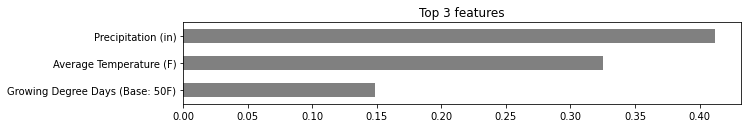

In [24]:
encoder = pipeline1.named_steps['onehotencoder']
rf = pipeline1.named_steps['decisiontreeregressor']
feature_names = encoder.transform(X_train).columns
importances = pd.Series(rf.feature_importances_, feature_names)

# Plot feature importances
n = 3
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

Evaluatation Metric Model 1 

In [25]:
from sklearn.model_selection import cross_val_score
k = 5
scores = cross_val_score(pipeline1, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)



MAE for 5 folds: [17.46716713 16.3092966  18.482941   14.51846215 15.99650953]


In [26]:
-scores.mean()

16.55487528136861

Build Model 2 RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [28]:
model = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train
model.fit(X_train, y_train)





Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samp

Feature importance model 2 

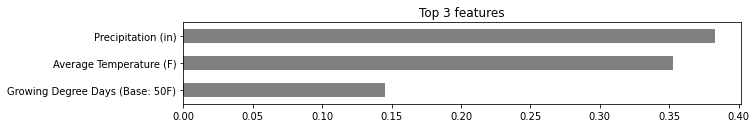

In [29]:
encoder = model.named_steps['ordinalencoder']
rf = model.named_steps['randomforestregressor']
feature_names = encoder.transform(X_train).columns
importances = pd.Series(rf.feature_importances_, feature_names)

# Plot feature importances
n = 3
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

Evaluate metric  model 2 

In [30]:
from sklearn.model_selection import cross_val_score
k = 5
scores = cross_val_score(model, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)


MAE for 5 folds: [16.09754773 14.83948274 17.14107665 12.70427341 14.36495719]


In [35]:
-scores.mean()

15.029467543472975

In [39]:

from xgboost import XGBRegressor

# Instantiate and fit one-hot encoder
encoder = ce.OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.fit_transform(X_test)

# Instantiate XGBRegressor and parameter tuning
model = XGBRegressor(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)
# Instantiate eval_set
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

# Fit model to the eval_set
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='mae', 
          early_stopping_rounds=50)

[00:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:34.047	validation_1-mae:92.0994
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:21.2816	validation_1-mae:75.7379
[2]	validation_0-mae:16.434	validation_1-mae:67.6756
[3]	validation_0-mae:14.6856	validation_1-mae:63.75
[4]	validation_0-mae:14.0646	validation_1-mae:61.892
[5]	validation_0-mae:13.8607	validation_1-mae:60.9315
[6]	validation_0-mae:13.6977	validation_1-mae:60.4805
[7]	validation_0-mae:13.6521	validation_1-mae:60.2476
[8]	validation_0-mae:13.6205	validation_1-mae:60.1284
[9]	validation_0-mae:13.5555	validation_1-mae:60.0899
[10]	validation_0-mae:13.4797	validation_1-mae:60.0727
[11]	validation_0-mae:13.4137	validation_1-mae:60.0816
[12]	validation_0-mae:13.3398	validation_1-mae:60.0809
[13]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Get permutation importances

In [40]:
import eli5
from eli5.sklearn import PermutationImportance
# Instantiate permuter for XGBRegressor
permuter = PermutationImportance(
    model,
    scoring='r2',
    n_iter=5,
    random_state=42
)
# Fit permuter to data from our model
permuter.fit(X_train_encoded, y_train)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.5,
                                             max_delta_step=0, max_depth=7,
                                             min_child_weight=1, missing=None,
                                             n_estimators=1000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                     

In [41]:
feature_names = X_train_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Growing Degree Days (Base: 50F)    0.000000
Year                               0.000000
Precipitation (in)                 0.429503
Month                              1.097116
Average Temperature (F)            1.333272
dtype: float64

Visualizations

In [42]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.3333 ± 0.0364,Average Temperature (F)
1.0971 ± 0.0281,Month
0.4295 ± 0.0129,Precipitation (in)
0 ± 0.0000,Year
0 ± 0.0000,Growing Degree Days (Base: 50F)


In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


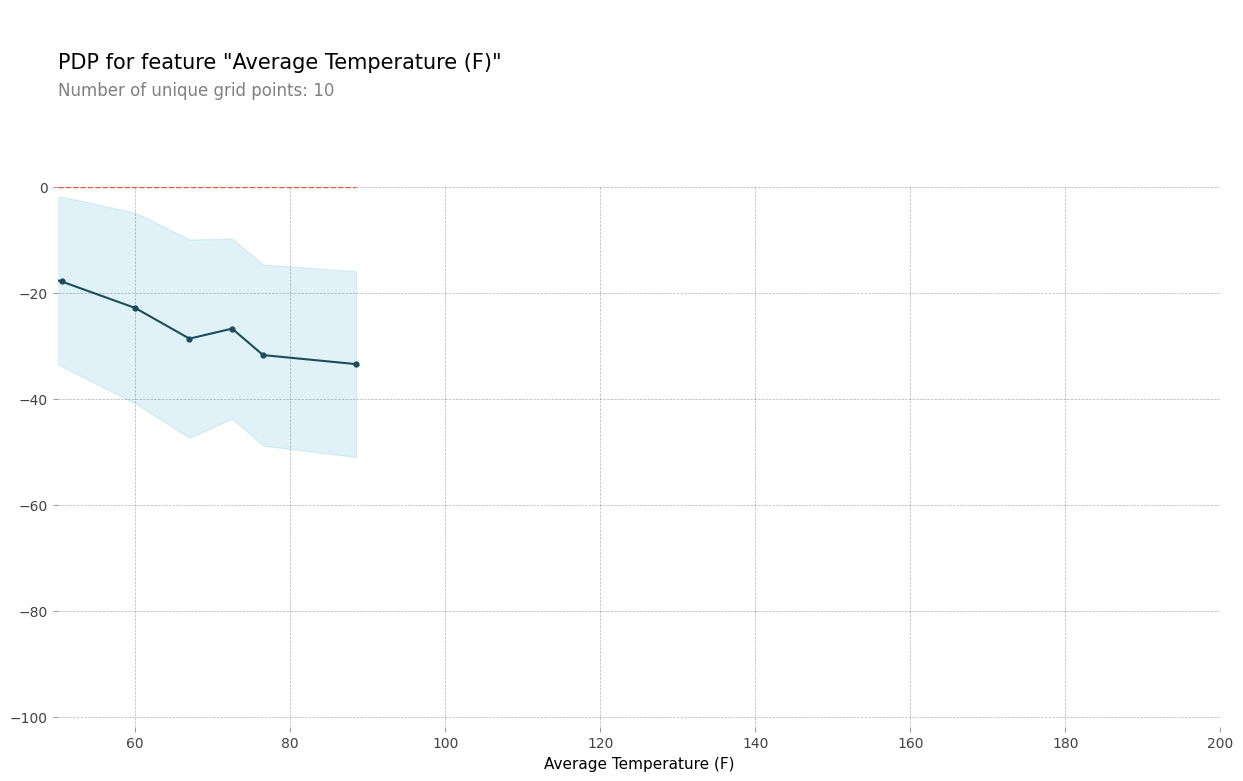

In [45]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Designate feature to analyze
feature = 'Average Temperature (F)'

# Instantiate isolated conditional plot
isolated = pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=feature
)
# Visualize pdp plot
pdp_plot(isolated, feature_name=feature)
plt.xlim((50, 200));

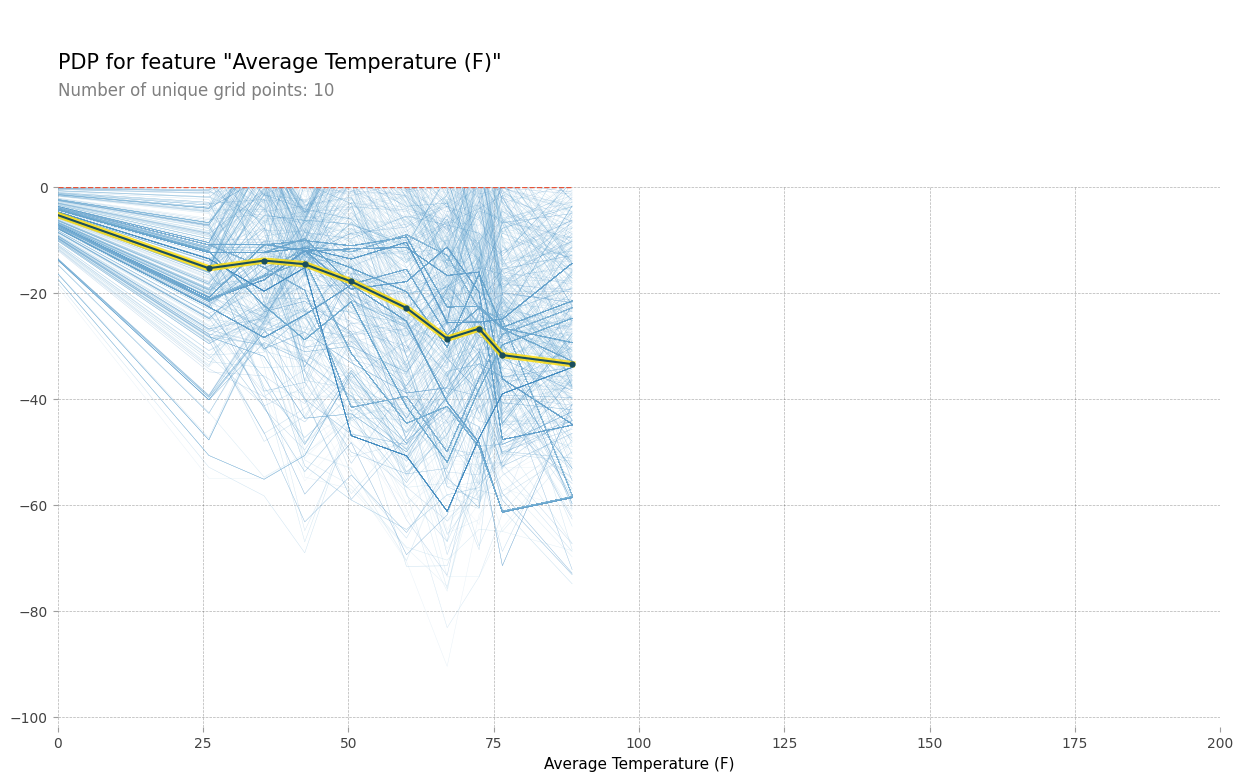

In [46]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1)

plt.xlim(0,200);

In [47]:

from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Average Temperature (F)', 'Growing Degree Days (Base: 50F)' ]

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


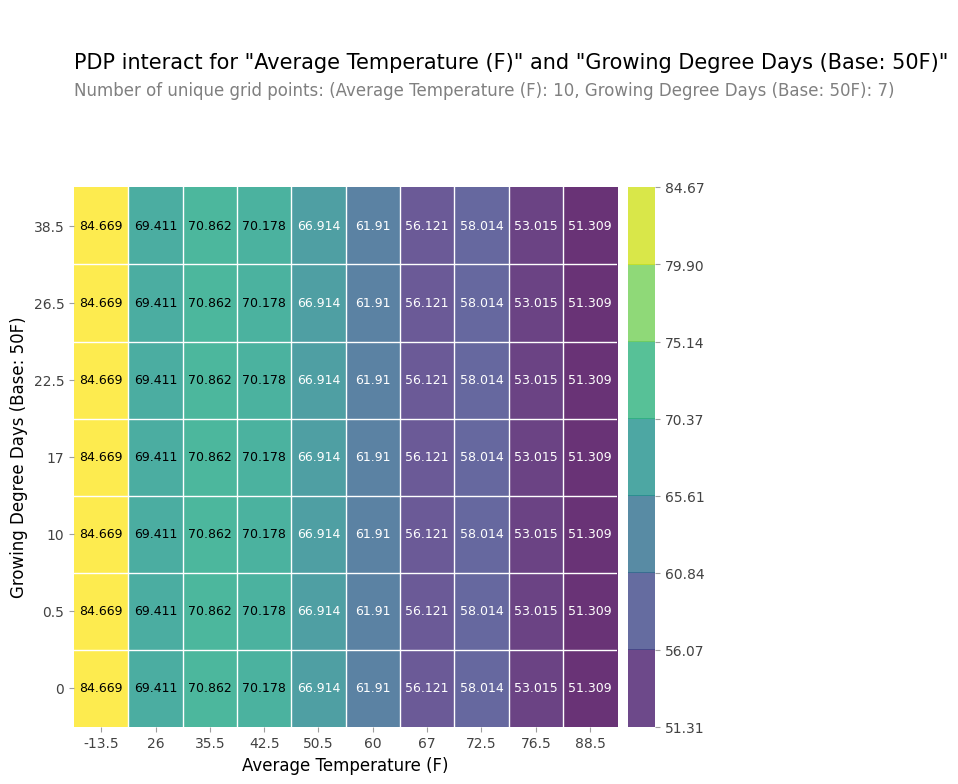

In [48]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [49]:
import shap
# Instantiate individual prediction
row = X_train_encoded.iloc[[0]]

# Instantiate TreeExplainer
explainer = shap.TreeExplainer(model)

# Pull shap values for individual observation
shap_values = explainer.shap_values(row)

# Visualize feature importance on individual prediction
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)